In [438]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils import data_dir

from tqdm import tqdm
from tabulate import tabulate

In [339]:
task_name = "axion2"
model_layer = "F_7"

## Grab our data

In [340]:
pfn_outputs = np.load(f"pfn_layer_outputs/{task_name}_{model_layer}_10%.npy")
pfn_outputs = pfn_outputs.T

# Stylize these labels for the sake of LaTeX
if "_" in model_layer:
    part, idx = model_layer.split("_")  # Something like ("F", "7")
    model_layer = f"{part}{idx}"
pfn_labels = [f"{model_layer}({i})" for i in range(pfn_outputs.shape[1])]

# Mask out things that are all zeros
all_zero_mask = np.all(pfn_outputs == 0, axis=1)
print(f"{np.sum(all_zero_mask)}/{pfn_outputs.shape[0]} {model_layer} outputs are all zero.")
print(f"  Indices: {np.where(all_zero_mask)[0]}")

pfn_outputs = pfn_outputs[~all_zero_mask]
pfn_labels = [pfn_labels[i] for i in np.where(~all_zero_mask)[0]]

print("PFN outputs shape:", pfn_outputs.shape)

17/128 F7 outputs are all zero.
  Indices: [  2   6  13  27  31  32  37  45  47  52  77 101 102 103 104 105 114]
PFN outputs shape: (111, 30000)


In [341]:
bdt_vars = []
for particle in ["pi0", "gamma", task_name]:
    bdt_var_npz = np.load(f"{data_dir}/processed/bdt_vars/{particle}_bdt_vars.npz")
    bdt_var_labels = list(bdt_var_npz.keys())
    bdt_vars.append(np.vstack([bdt_var_npz[key] for key in bdt_var_labels])[:,::10])

bdt_vars = np.hstack(bdt_vars)
print("BDT vars shape: ", bdt_vars.shape)

BDT vars shape:  (53, 30000)


In [342]:
all_labels = pfn_labels + bdt_var_labels
all_vars = np.vstack([pfn_outputs, bdt_vars])

In [343]:
print(all_vars.shape)

(164, 30000)


## Evaluate correlations

In [344]:
# Wooooo...
corr_mat = np.corrcoef(all_vars)

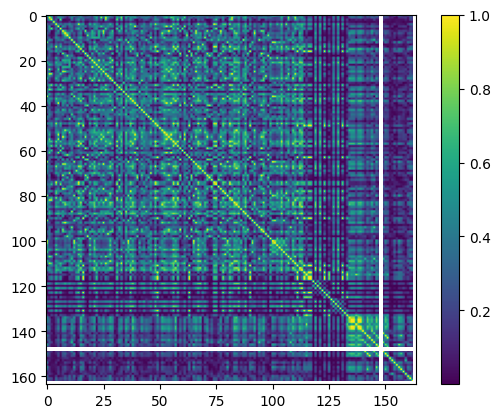

In [345]:
plt.imshow(np.abs(corr_mat))
plt.colorbar()

There's a couple variables with zero variance amongst the BDT variables, but that's ok.

## Identify which variables correlate highly

In [346]:
# Variables that correlate very closely (>99%) with another
#   in their own group (i.e. PFN with PFN or BDT var with BDT var)
# Dictionary maps labels to their "representative" in a disjoint-set-style
#   data structure.
rep = {label: label for label in all_labels}
def get_rep(label):
    cur = label
    while rep[cur] != cur: cur = rep[cur]
    return cur

def join(label1, label2):
    rep[get_rep(label1)] = get_rep(label2)

In [370]:
# Threshold for significant correlation
thresh = 0.9

all_corrs = {}

for i in range(len(all_labels)):
    for j in range(i, len(all_labels)):
        if i == j: continue
        label1 = all_labels[i]
        label2 = all_labels[j]
        corr = corr_mat[i,j]
        all_corrs[(label1, label2)] = all_corrs[(label2, label1)] = corr
        
        if abs(corr) > thresh:
            if (label1 in pfn_labels and label2 in pfn_labels) or \
               (label1 in bdt_var_labels and label2 in bdt_var_labels):
                if "F" in label1:
                    print(label1[3:-1], label2[3:-1])
                else:
                    print(label1, label2)
                join(label2, label1)

0 43
0 75
0 91
0 117
1 30
1 93
5 17
5 85
7 48
7 63
7 65
9 29
9 64
9 76
9 82
9 88
10 108
12 81
14 98
15 43
15 75
15 117
17 58
17 66
17 85
17 86
17 92
18 67
18 126
19 59
19 73
19 106
20 69
20 111
21 72
21 115
23 26
28 65
29 76
29 88
29 108
30 93
30 127
33 113
34 126
38 66
38 68
38 86
38 92
39 84
40 127
42 98
43 75
43 117
44 89
46 67
48 63
48 65
48 71
49 74
49 83
56 81
58 66
58 78
58 85
58 86
58 92
59 73
59 106
61 95
63 65
63 71
64 82
65 71
66 68
66 92
66 121
67 126
68 86
68 92
69 74
69 82
69 111
72 115
73 106
74 111
75 91
75 117
76 88
76 108
79 95
82 111
85 92
86 92
90 123
91 117
93 127
99 121
110 125
total_e secondlayer_e
total_e depth_weighted_total_e
total_e depth_weighted_total_e2
total_e secondlayer_x2
total_e secondlayer_y2
prelayer_e prelayer_x2
firstlayer_e firstlayer_x2
secondlayer_e depth_weighted_total_e
secondlayer_e depth_weighted_total_e2
secondlayer_e secondlayer_x2
secondlayer_e secondlayer_y2
thirdlayer_e thirdlayer_y2
depth_weighted_total_e depth_weighted_total_e2
depth

In [371]:
print(f"{'representative label':<25} | represented labels")
print("=" * 100)
for label in all_labels:
    represents = [other for other in all_labels if get_rep(other) == label and other != label]
    if len(represents) > 0:
        print(f"{label:<25} | {', '.join(represents)}")

representative label      | represented labels
F7(15)                    | F7(0), F7(43), F7(75), F7(91), F7(117)
F7(19)                    | F7(59), F7(73), F7(106)
F7(20)                    | F7(9), F7(10), F7(29), F7(49), F7(64), F7(69), F7(74), F7(76), F7(82), F7(83), F7(88), F7(108), F7(111)
F7(21)                    | F7(72), F7(115)
F7(23)                    | F7(26)
F7(28)                    | F7(7), F7(48), F7(63), F7(65), F7(71)
F7(33)                    | F7(113)
F7(39)                    | F7(84)
F7(40)                    | F7(1), F7(30), F7(93), F7(127)
F7(42)                    | F7(14), F7(98)
F7(44)                    | F7(89)
F7(46)                    | F7(18), F7(34), F7(67), F7(126)
F7(56)                    | F7(12), F7(81)
F7(79)                    | F7(61), F7(95)
F7(90)                    | F7(123)
F7(99)                    | F7(5), F7(17), F7(38), F7(58), F7(66), F7(68), F7(78), F7(85), F7(86), F7(92), F7(121)
F7(110)                   | F7(125)
total_e         

## Find interesting correlations

In [372]:
banned = {
    "secondlayer_e",
    "depth_weighted_total_e2",
    "depth_weighted_total_e",
}

In [402]:
thresh = 0.9

chosen_vars = set()
for i in range(len(pfn_labels)):
    for j in range(len(bdt_var_labels)):
        label1, label2 = pfn_labels[i], bdt_var_labels[j]
        if label1 in banned or label2 in banned: continue
        
        corr = all_corrs[(label1, label2)]
        if abs(corr) > thresh:
            print(f"{corr:.4f}", label1, label2)
            chosen_vars.update((label1, label2))
    
chosen_vars = list(chosen_vars)

0.9963 F7(19) total_e
0.9874 F7(19) secondlayer_x2
0.9878 F7(19) secondlayer_y2
0.9757 F7(59) total_e
0.9704 F7(59) secondlayer_x2
0.9713 F7(59) secondlayer_y2
0.9960 F7(73) total_e
0.9874 F7(73) secondlayer_x2
0.9879 F7(73) secondlayer_y2
0.9052 F7(96) firstlayer_e
0.9073 F7(96) firstlayer_x2
0.9960 F7(106) total_e
0.9869 F7(106) secondlayer_x2
0.9873 F7(106) secondlayer_y2


In [403]:
def plot_corr(var1, var2, **kwargs):
    plt.scatter(
        all_vars[all_labels.index(var1)],
        all_vars[all_labels.index(var2)],
        linewidth=0,
        **kwargs,
    )
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f"{var1} vs {var2}\ncorrelation: {all_corrs[(var1, var2)]:.4f}")

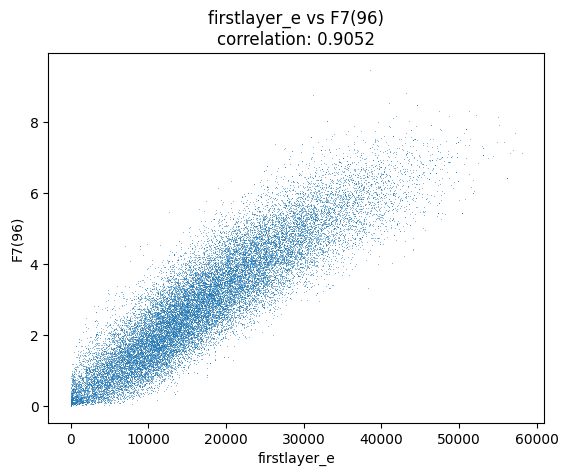

In [404]:
plot_corr("firstlayer_e", "F7(96)", s=0.2)

# Giant matrix

In [442]:
n_vars = len(chosen_vars)
chosen_vars.sort()

In [ ]:
scale = 2
fig, axs = plt.subplots(n_vars, n_vars, figsize=(scale*n_vars, scale*n_vars))

for i in tqdm(range(n_vars)):
    for j in range(n_vars):
        var1, var2 = chosen_vars[i], chosen_vars[j]
        
        axs[i,j].get_xaxis().set_ticks([])
        axs[i,j].get_yaxis().set_ticks([])
        if i == 0:
            axs[i,j].xaxis.set_label_position('top') 
            axs[i,j].set_xlabel(var2, labelpad=20, fontsize="large")
        if j == 0:
            axs[i,j].set_ylabel(var1, labelpad=20, fontsize="large")
        
        if j <= i: continue
        axs[i,j].scatter(
            all_vars[all_labels.index(var1)],
            all_vars[all_labels.index(var2)],
            s=0.2, linewidth=0
        )

plt.savefig("/usatlas/u/wifeng/output.png", dpi=300)